In [1]:
import pyomo.environ as pyo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Load Data

In [2]:
plant_properties = pd.read_csv('plantProps - Q1.csv').to_numpy()
plant_properties

array([['FuelCost ($/MWh)', 30, 25, 45, 60],
       ['OperatingCost ($/h)', 20, 30, 50, 10],
       ['StartupCost ($/switch)', 800, 650, 200, 80],
       ['MinGenerationLevel (MW)', 120, 90, 40, 3],
       ['MaxGenerationLevel (MW)', 800, 250, 200, 120],
       ['RampUpLimit (MW/h)', 30, 40, 80, 900],
       ['RampDownLimit (MW/h)', 50, 50, 100, 1800],
       ['MinimumUpTime (h)', 4, 3, 5, 1],
       ['MinimumDownTime (h)', 3, 1, 4, 1]], dtype=object)

In [3]:
plant_properties = plant_properties[:,1:]
plant_properties

array([[30, 25, 45, 60],
       [20, 30, 50, 10],
       [800, 650, 200, 80],
       [120, 90, 40, 3],
       [800, 250, 200, 120],
       [30, 40, 80, 900],
       [50, 50, 100, 1800],
       [4, 3, 5, 1],
       [3, 1, 4, 1]], dtype=object)

In [4]:
load_profile = pd.read_csv('loadProfile - Q1.csv').to_numpy()
load_profile = load_profile[:,1]
load_profile

array([185.4828134, 148.8480317, 136.006771 , 134.7357675, 137.3737109,
       153.9476645, 199.0182488, 243.3924932, 318.7554353, 385.2574395,
       413.3359044, 421.1049789, 405.6551978, 383.64289  , 362.4389527,
       378.3462924, 531.8660873, 641.4227544, 521.1043771, 474.3723767,
       422.713907 , 340.1245408, 250.1899275, 171.9553108, 139.0226624,
       119.2198799, 110.1121918, 100.       , 124.2801057, 182.8429973,
       264.5152453, 334.9288398, 406.9497271, 457.0100045, 480.2948178,
       492.3043364, 471.2083671, 447.5119297, 428.9733058, 463.8135369,
       627.205469 , 752.0483629, 597.8954387, 561.3042094, 488.68875  ,
       364.8736097, 264.2728658, 211.683914 , 192.6028372, 180.247302 ,
       195.7312391, 196.2442119, 259.2080246, 403.9510175, 666.6131807,
       754.9756656, 756.1715905, 737.0350648, 777.0478798, 732.1612308,
       687.980223 , 711.462273 , 683.291965 , 690.0044218, 858.9195055,
       943.4656682, 778.9301866, 726.9369313, 669.751109 , 563.0

In [5]:
n_hours = load_profile.shape[0]
time = np.arange(1,n_hours+1)

In [6]:
generation_target = load_profile*1.05

In [ ]:
installed_capacity = sum(plant_properties[4,:])

In [ ]:
if installed_capacity < max(generation_target):
    print('Error! Maximum of load profile {:2f} MW is above installed capacity {:2f} MW!'.format(max(generation_target),
    installed_capacity))

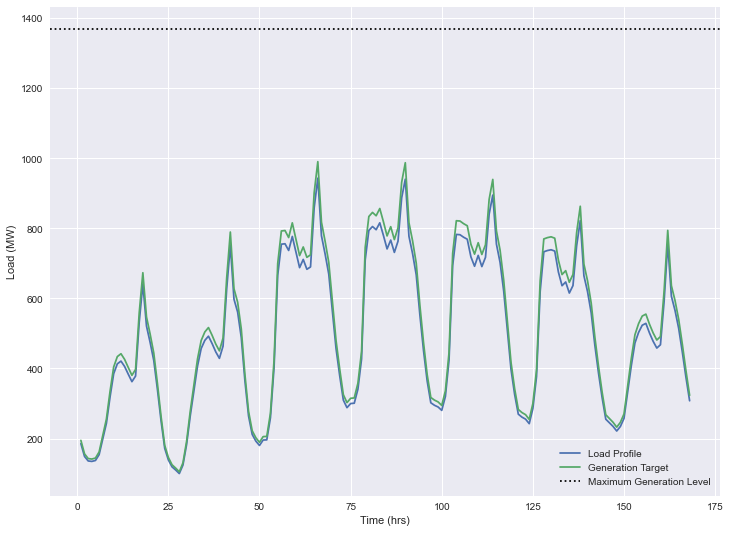

In [7]:
# Visualize data
plt.figure(figsize=(12, 9))
plt.clf()
plt.plot(time, load_profile)
plt.plot(time, generation_target)
plt.axhline(y=installed_capacity, color="black", linestyle=":")
plt.xlabel('Time (hrs)')
plt.ylabel('Load (MW)')
plt.legend(['Load Profile','Generation Target','Maximum Generation Level'],loc='best')

# Define Constraints

In [8]:
fuel_cost = plant_properties[0,:]
operating_cost = plant_properties[1,:]
startup_cost = plant_properties[2,:]
min_generation_level = plant_properties[3,:]
max_generation_level = plant_properties[4,:]
ramp_up_limit = plant_properties[5,:]
ramp_down_limit = plant_properties[6,:]
minimum_up_time = plant_properties[7,:]
minimum_down_time = plant_properties[8,:]

# Define Optimization Problem

In [9]:
model = pyo.ConcreteModel()

#index sets initialization
model.hours=pyo.Set(initialize=np.array([i for i in range(0,n_hours)]))
model.hours_1N=pyo.Set(initialize=np.array([i for i in range(1,n_hours)]))

#decision variables configuration
model.coal_old = pyo.Var(model.hours, domain = pyo.NonNegativeReals)
model.coal_new = pyo.Var(model.hours, domain = pyo.NonNegativeReals)
model.gas = pyo.Var(model.hours, domain = pyo.NonNegativeReals)
model.peaker = pyo.Var(model.hours, domain = pyo.NonNegativeReals)

model.max_generation=pyo.Var(model.hours, domain = pyo.NonNegativeReals)
model.total_generation=sum(model.coal_old[j]+model.coal_new[j]+model.gas[j]+model.peaker[j] for j in model.hours)

# Define Objective Function

In [10]:
model.obj=pyo.Objective(expr=sum(model.coal_old[i]*fuel_cost[0]+
model.coal_new[i]*fuel_cost[1]+
model.gas[i]*fuel_cost[2]+
model.peaker[i]*fuel_cost[3]
for i in model.hours))

# Solve Optimization

In [11]:
pyo.SolverFactory('glpk', executable="GPLK/w64/glpsol.exe").solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 0.0, 'Upper bound': 0.0, 'Number of objectives': 1, 'Number of constraints': 1, 'Number of variables': 673, 'Number of nonzeros': 1, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.0444483757019043}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}